# RoI Align numba implementation

In [1]:
%matplotlib inline

import torch
from numba import cuda, float32
import math
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [2]:
# !conda install cudatoolkit -y

## Helper functions
These functions are used to get data pointer from pytorch tensor and pass it to numba context.

In [3]:
def _tensor_dtype(tensor):
    if isinstance(tensor, torch.cuda.FloatTensor):
        return np.dtype('float32')
    if isinstance(tensor, torch.cuda.ByteTensor):
        return np.dtype('uint8')
    if isinstance(tensor, torch.cuda.LongTensor):
        return np.dtype('int64')
    if isinstance(tensor, torch.cuda.CharTensor):
        return np.dtype('int8')
    raise Exception(f"Unsupported tensor type {type(tensor)}")


if int(os.environ.get('NUMBA_ENABLE_CUDASIM', '0')) == 0:
    from numba.cuda.cudadrv.driver import MemoryPointer
    from numba.cuda.cudadrv.devicearray import DeviceNDArray
    import ctypes

    def numba_tensor(tensor):
        element_size = tensor.element_size()
        dtype = _tensor_dtype(tensor)
        strides = [i * element_size for i in tensor.stride()]
        stream = torch.cuda.current_stream().cuda_stream
        pointer = MemoryPointer(None, ctypes.c_ulong(tensor.data_ptr()), tensor.numel() * element_size)
        array = DeviceNDArray(tensor.size(), strides, dtype, gpu_data=pointer, stream=stream)
        return array
else:
    def numba_tensor(tensor):
        dtype = _tensor_dtype(tensor)
        if dtype == np.dtype('int8'):
            return tensor.int().cpu().np().astype(dtype)
        return tensor.cpu().np()

## Bilinear interpolation of features

In [4]:
@cuda.jit(device=True, inline=True)
def bilinear_interpolate(features, roi_batch_ind, c, height, width, y, x):
    if y < -1.0 or y > height or x < -1.0 or x > width:
        return float32(0.0)
    if y < 0:
        y = 0
    if x < 0:
        x = 0

    y_low = int(y)
    x_low = int(x)

    if y_low >= height - 1:
        y_high = y_low = height - 1
        y = float32(y_low)
    else:
        y_high = y_low + 1

    if x_low >= width - 1:
        x_high = x_low = width - 1
        x = float32(x_low)
    else:
        x_high = x_low + 1

    ly = float32(y - y_low)
    lx = float32(x - x_low)
    hy = float32(1.0 - ly)
    hx = float32(1.0 - lx)

    v1 = features[roi_batch_ind, c, y_low, x_low]
    v2 = features[roi_batch_ind, c, y_low, x_high]
    v3 = features[roi_batch_ind, c, y_high, x_low]
    v4 = features[roi_batch_ind, c, y_high, x_high]

    w1 = hy * hx
    w2 = hy * lx
    w3 = ly * hx
    w4 = ly * lx
    val = w1 * v1 + w2 * v2 + w3 * v3 + w4 * v4

    return val

## RoI Align forward kernel

In [5]:
@cuda.jit
def roi_align_forward_kernel(features, rois, spatial_scale, output):
    grid = cuda.grid(1)
    size = cuda.gridsize(1)
    nthreads = output.size

    channels = features.shape[1]
    height = features.shape[2]
    width = features.shape[3]

    aligned_height = output.shape[2]
    aligned_width = output.shape[3]

    for index in range(grid, nthreads, size):
        pw = index % aligned_width
        ph = (index // aligned_width) % aligned_height
        c = (index // aligned_width // aligned_height) % channels
        n = index // aligned_width // aligned_height // channels

        roi_batch_ind = int(rois[n, 0])
        roi_start_w = rois[n, 1] * spatial_scale
        roi_start_h = rois[n, 2] * spatial_scale
        roi_end_w = rois[n, 3] * spatial_scale
        roi_end_h = rois[n, 4] * spatial_scale

        roi_width = max(roi_end_w - roi_start_w, float32(1.0))
        roi_height = max(roi_end_h - roi_start_h, float32(1.0))
        bin_size_h = float32(roi_height) / float32(aligned_height)
        bin_size_w = float32(roi_width) / float32(aligned_width)

        # TODO: assuming sampling ratio = 2
        roi_bin_grid_h = 2
        roi_bin_grid_w = 2

        count = roi_bin_grid_h * roi_bin_grid_w
        output_val = float32(0.0)

        for iy in range(roi_bin_grid_h):
            y = roi_start_h + ph * bin_size_h + float32(iy + float32(0.5)) * bin_size_h / float32(roi_bin_grid_h)
            for ix in range(roi_bin_grid_w):
                x = roi_start_w + pw * bin_size_w + float32(ix + float32(0.5)) * bin_size_w / float32(roi_bin_grid_w)
                val = bilinear_interpolate(features, roi_batch_ind, c, height, width, y, x)
                output_val += val
        output[n, c, ph, pw] = output_val / count

## Gradient of bilinear interpolation

In [6]:
@cuda.jit(device=True, inline=True)
def bilinear_interpolate_gradient(grad_output, grad_input, roi_batch_ind, c, height, width, y, x):
    if y < -1.0 or y > height or x < -1.0 or x > width:
        return
    if y < 0:
        y = 0
    if x < 0:
        x = 0

    y_low = int(y)
    x_low = int(x)

    if y_low >= height - 1:
        y_high = y_low = height - 1
        y = float32(y_low)
    else:
        y_high = y_low + 1

    if x_low >= width - 1:
        x_high = x_low = width - 1
        x = float32(x_low)
    else:
        x_high = x_low + 1

    ly = float32(y - y_low)
    lx = float32(x - x_low)
    hy = float32(1.0 - ly)
    hx = float32(1.0 - lx)

    w1 = hy * hx
    w2 = hy * lx
    w3 = ly * hx
    w4 = ly * lx

    cuda.atomic.add(grad_input, (roi_batch_ind, c, y_low, x_low), grad_output * w1)
    cuda.atomic.add(grad_input, (roi_batch_ind, c, y_low, x_high), grad_output * w2)
    cuda.atomic.add(grad_input, (roi_batch_ind, c, y_high, x_low), grad_output * w3)
    cuda.atomic.add(grad_input, (roi_batch_ind, c, y_high, x_high), grad_output * w4)

## RoI Align backward kernel

In [7]:
@cuda.jit
def roi_align_backward_kernel(rois, spatial_scale, grad_output, grad_input):
    grid = cuda.grid(1)
    size = cuda.gridsize(1)
    nthreads = grad_output.size

    channels = grad_input.shape[1]
    height = grad_input.shape[2]
    width = grad_input.shape[3]

    aligned_height = grad_output.shape[2]
    aligned_width = grad_output.shape[3]

    for index in range(grid, nthreads, size):
        pw = index % aligned_width
        ph = (index // aligned_width) % aligned_height
        c = (index // aligned_width // aligned_height) % channels
        n = index // aligned_width // aligned_height // channels

        roi_batch_ind = int(rois[n, 0])
        roi_start_w = rois[n, 1] * spatial_scale
        roi_start_h = rois[n, 2] * spatial_scale
        roi_end_w = rois[n, 3] * spatial_scale
        roi_end_h = rois[n, 4] * spatial_scale

        roi_width = max(roi_end_w - roi_start_w, float32(1.0))
        roi_height = max(roi_end_h - roi_start_h, float32(1.0))
        bin_size_h = float32(roi_height) / float32(aligned_height)
        bin_size_w = float32(roi_width) / float32(aligned_width)

        # TODO: assuming sampling ratio = 2
        roi_bin_grid_h = 2
        roi_bin_grid_w = 2

        count = roi_bin_grid_h * roi_bin_grid_w

        for iy in range(roi_bin_grid_h):
            y = roi_start_h + ph * bin_size_h + float32(iy + float32(0.5)) * bin_size_h / float32(roi_bin_grid_h)
            for ix in range(roi_bin_grid_w):
                x = roi_start_w + pw * bin_size_w + float32(ix + float32(0.5)) * bin_size_w / float32(roi_bin_grid_w)

                grad = grad_output[n, c, ph, pw] / count
                bilinear_interpolate_gradient(grad, grad_input, roi_batch_ind, c, height, width, y, x)


## Pytorch function for RoI Align
Run the kernels and wrap the code into pytorch function

In [8]:
def roi_align_forward(features, rois, spatial_scale, aligned_height, aligned_width):
    n_rois = rois.shape[0]
    channels = features.shape[1]

    threads_per_block = 512
    output = features.new(n_rois, channels, aligned_height, aligned_width)
    blocks = (output.numel() + threads_per_block - 1) // threads_per_block

    stream = torch.cuda.current_stream().cuda_stream
    roi_align_forward_kernel[blocks,
                             threads_per_block,
                             stream](numba_tensor(features), numba_tensor(rois), float32(spatial_scale), numba_tensor(output))
    return output


def roi_align_backward(rois, spatial_scale, input_shape, grad_output: torch.cuda.FloatTensor):
    threads_per_block = 512
    grad_input = grad_output.data.new(*input_shape).fill_(0.0)
    blocks = (grad_output.numel() + threads_per_block - 1) // threads_per_block

    stream = torch.cuda.current_stream().cuda_stream
    roi_align_backward_kernel[blocks,
                              threads_per_block,
                              stream](numba_tensor(rois), float32(spatial_scale), numba_tensor(grad_output.data), numba_tensor(grad_input))
    return grad_input


class RoIAlign(torch.autograd.Function):
    @staticmethod
    def forward(ctx, features, rois, spatial_scale, aligned_height, aligned_width):
        ctx.save_for_backward(rois)
        ctx.input_shape = features.shape
        ctx.spatial_scale = spatial_scale
        ctx.aligned_height = aligned_height
        ctx.aligned_width = aligned_width

        return roi_align_forward(features, rois, spatial_scale, aligned_height, aligned_width)

    @staticmethod
    def backward(ctx, grad_output):
        rois, = ctx.saved_tensors
        return torch.autograd.Variable(roi_align_backward(rois, ctx.spatial_scale, ctx.input_shape, grad_output)), None, None, None, None

# Simple visualizations

In [9]:
from fastai import *
from fastai.vision import *

path = untar_data(URLs.PETS)

img_size = 224
image = open_image(path / "images" / "Ragdoll_47.jpg").apply_tfms([], size=img_size)

path_anno = path/'annotations'
path_img = path/'images'

fnames = get_image_files(path_img)

np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

data = ImageDataBunch\
    .from_name_re(path_img, fnames, pat,
        size=img_size, bs=1)

learn = cnn_learner(data, models.resnet34)

/home/marcin/github/fastai/fastai/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


Load a cat image and draw some predefined bounding box.

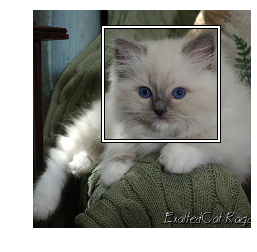

In [10]:
roi = np.array([0.075, 0.32, 0.6, 0.85])
bbox = ImageBBox.create(*image.size, [roi * img_size], labels=[0], classes=[""])
figsize=(4,4)
image.show(y=bbox, figsize=figsize)

In [11]:
out = learn.model[0](image.data[None, ...].cuda())
out.shape

torch.Size([1, 512, 7, 7])

Compute ResNet-34 feature maps (just before adaptive pooling)

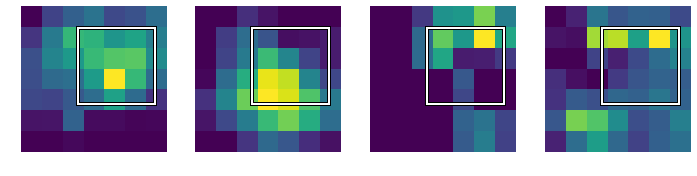

In [12]:
_, axs = plt.subplots(1,4, figsize=(12,4))
bbox = ImageBBox.create(*image.size, [roi * 7], labels=[0], classes=[""])
for channel, ax  in enumerate(axs):
    Image(out[0, channel][None, ...].data.cpu()).show(ax=ax, y=bbox)

Run RoI Align

In [13]:
top, left, bottom, right = roi
rois = torch.FloatTensor([[0, left, top, right, bottom]]).cuda()
aligned = RoIAlign.apply(out, rois, 7, 14, 14)
aligned.shape

torch.Size([1, 512, 14, 14])

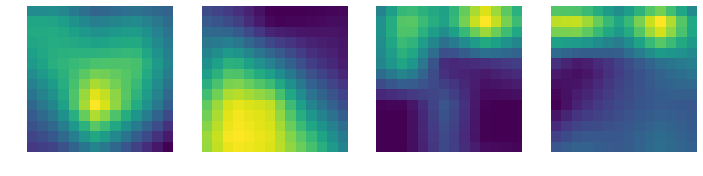

In [14]:
_, axs = plt.subplots(1,4, figsize=(12,4))
for channel, ax  in enumerate(axs):
    Image(aligned[0, channel][None, ...].data.cpu()).show(ax=ax)